## Import Libraries

In [2]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from pickletools import optimize
from numpy import average
from torch.utils.data import DataLoader 
from torchvision import transforms, datasets 
import torch.optim as optim 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

## Build Model

In [3]:
class MNIST_Classifier(nn.Module):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()   

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32,  kernel_size=3,  stride=1,  padding=0)  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,  kernel_size=3,  stride=1,  padding=0)                                           

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)

        self.fc1 = nn.Linear(64*20*20, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

     #    self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1( F.relu( self.conv1(x) ))
        x = self.pool1( F.relu( self.conv2(x) ))

        # print(x.shape)
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

     #    x = self.softmax(x)

        return x

## Check Model Statues

In [4]:
fake_data = torch.rand((32, 1, 28, 28))
model = MNIST_Classifier()

print(model.forward(fake_data))

tensor([[ 4.7012e-02,  1.8738e-02, -1.4273e-04,  1.1713e-01,  6.6123e-02,
          7.2576e-02, -4.8202e-02, -1.1526e-01, -7.4869e-02,  6.7001e-02],
        [ 4.7440e-02,  1.8285e-02, -1.4157e-03,  1.1879e-01,  6.6875e-02,
          7.1553e-02, -4.8141e-02, -1.1474e-01, -7.5494e-02,  6.7304e-02],
        [ 4.6233e-02,  1.8073e-02,  4.4403e-04,  1.1679e-01,  6.6275e-02,
          7.1697e-02, -4.8450e-02, -1.1598e-01, -7.5454e-02,  6.7101e-02],
        [ 4.5973e-02,  1.8021e-02, -1.0451e-03,  1.1797e-01,  6.6621e-02,
          7.1245e-02, -4.8695e-02, -1.1384e-01, -7.5158e-02,  6.8290e-02],
        [ 4.5231e-02,  1.8680e-02, -1.8438e-04,  1.1794e-01,  6.6005e-02,
          7.1070e-02, -4.7873e-02, -1.1497e-01, -7.6638e-02,  6.8482e-02],
        [ 4.8636e-02,  1.7359e-02, -7.2243e-04,  1.1783e-01,  6.5459e-02,
          7.2129e-02, -4.7934e-02, -1.1419e-01, -7.5873e-02,  6.7639e-02],
        [ 4.7211e-02,  1.8240e-02, -4.6466e-04,  1.1813e-01,  6.7317e-02,
          7.2146e-02, -4.7799e-0

## Transformations

In [5]:
transforms_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5,], std=[0.5,])])
transforms_test  = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5,], std=[0.5,])])

## Datasets and DataLoader

In [6]:
datasets_train = datasets.MNIST(root='data/', download=True, train=True,  transform=transforms_train)
datasets_test  = datasets.MNIST(root='data/', download=True, train=False, transform=transforms_test)

dataloader_train = DataLoader(dataset=datasets_train, batch_size=32, shuffle=True)
dataloader_test  = DataLoader(dataset=datasets_test,  batch_size=32, shuffle=True)

## Instantiate Model, Loss Function, and Activation Function

In [7]:
model = MNIST_Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

## Start Training

In [ ]:
epochs, all_train_losses, all_test_losses, all_accuracies = 10, [], [], []

for epoch in range(epochs):
     train_losses, test_losses, test_accuracies = 0, 0, 0 
     for idx_train, (feature_train, target_train) in enumerate(iter(dataloader_train)):

          optimizer.zero_grad()

          prediction_train = model.forward(feature_train)
          loss_train = criterion(prediction_train, target_train)
          loss_train.backward()
          optimizer.step()

          train_losses += loss_train.item()

     average_train_losses = train_losses/len(dataloader_train)
     all_train_losses.append(average_train_losses)

     model.eval()
     with torch.no_grad():
          for idx_test, (feature_test, target_test) in enumerate(iter(dataloader_test)): 

               prediction_test = model.forward(feature_test)
               loss_test = criterion(prediction_test, target_test)

               test_losses += loss_test.item() 

               prediction_class = torch.argmax(prediction_test, dim=1)
               test_accuracies += accuracy_score(prediction_class, target_test)

          average_test_losses = test_losses/len(dataloader_test)
          all_test_losses.append(average_test_losses)

          average_test_accuracies = test_accuracies/len(dataloader_test)
          all_accuracies.append(average_test_accuracies)
     model.train()

     print(f'{epoch+1:3}/{epochs} :  Train Loss : {average_train_losses:.6f}  |  Test Loss : {average_test_losses:.6f}  | Accuracy : {average_test_accuracies:.6f}')

## Save Trained Model

In [9]:
torch.save({"model_state": model.state_dict(), "input_size": 28*28}, 'trained_model')

## Plot Trained Results

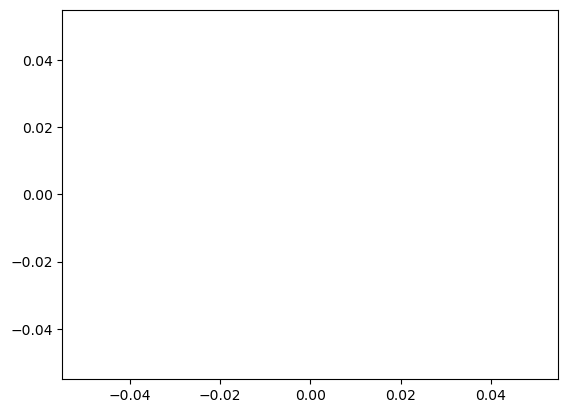

In [10]:
plt.plot(all_train_losses, label='Training Losses')
plt.plot(all_test_losses,  label='Testing Lossess')
plt.plot(all_accuracies,   label='Accuracy')
plt.show()

## Load Trained Model

In [11]:
train_model = torch.load('trained_model')
model_state = train_model['model_state']

model = MNIST_Classifier()
model.load_state_dict(model_state)

<All keys matched successfully>

## Make Predictions

In [12]:
def make_predict(image_path, model):
     preprocessor = transforms.Compose([ transforms.Grayscale()   , transforms.Resize((28, 28)),  transforms.ToTensor(),  transforms.Normalize([0.5], [0.5])  ])
     classes_dict = {0:'Zero',  1:'One',   2:'Two',  3:'Three',  4:'Four',  5:'Five',   6:'Six',  7:'Seven',   8:'Eight',   9:'Nine' }

     image = Image.open(image_path)
     processed_image = preprocessor(image)
     processed_image = processed_image.view(1, *processed_image.shape)

     model.eval()
     with torch.no_grad():
          prediction = model.forward(processed_image)
          _, prediction_class = torch.max(prediction, dim=1)

     plt.imshow(image, cmap='gray')
     plt.title(f'Prediction digit:  {prediction_class.item()}    ({classes_dict[prediction_class.item()]})', fontsize=15)
     plt.show()

     return

     

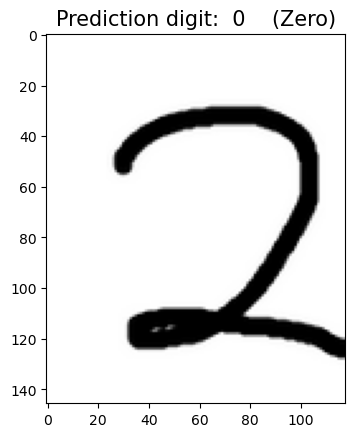

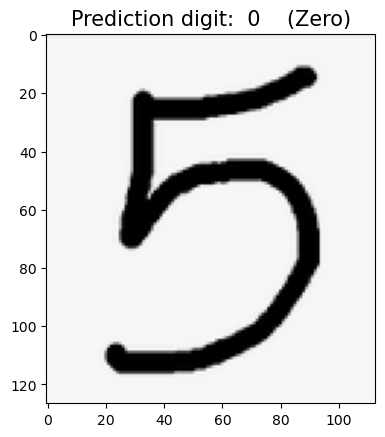

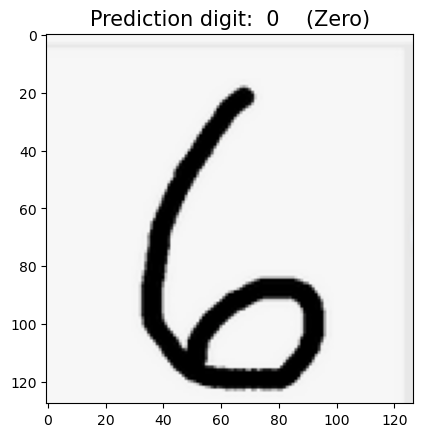

In [13]:
from PIL import ImageTk, Image

number = ['2', '5', '6']

root_path = "C:/Users/zorve/OneDrive/Documents/github datasets/cat_vs_dog/check/img_"
root_path = "C:/Users/zorve/OneDrive/Documents/github datasets/4.3/"

# for i in range(0, 11, 1):
for i in number:    
     image_path_arg = root_path +  str(i) + ".png"
     image_path = image_path_arg
     make_predict(image_path, model)